### Import Classes

In [ ]:
%run ./ActorCricitSimulator

### Data

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

data_origin = spark.read.load(home + 'data')
splits = data_origin.randomSplit([0.8, 0.2], 100)

data = splits[0].toPandas()
data_test = splits[1]

cats = spark.read.format('delta').load((home + 'cat_seg'))
clusters = cats.select('cluster').distinct().count()

state_cols = ['orders_{0}'.format(i) for i in range(clusters)]
action_cols = ['rest_{0}'.format(j) for j in range(clusters)]

states = data[state_cols].drop_duplicates()
states['rand'] = np.random.rand(states.shape[0])
#display(states.head())
states = states.sort_values(by='rand').drop('rand',axis=1)
states = t.tensor(states.values)

actions = t.tensor(data[action_cols].drop_duplicates().values)

#print(state_cols)
print('States: ', states.shape)
print('Actions: ', actions.shape)

/databricks/spark/python/pyspark/sql/pandas/utils.py:79: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [TARGET] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 warnings.warn(
States: torch.Size([4575, 50])
Actions: torch.Size([227, 50])

### Simulator

In [ ]:
simulator = RecModel(len(state_cols)+len(action_cols), 2)
checkpoint = t.load('checkpoint.pt')
#print(checkpoint['model_dict'])

simulator.load_state_dict(checkpoint['model_dict'])
simulator.eval()
print(simulator)

layers: [100, 50]
RecModel(
 (total_mc): Sequential(
 (0): Sequential(
 (0): Linear(in_features=100, out_features=50, bias=True)
 (1): ReLU()
 )
 )
 (linear): Linear(in_features=50, out_features=1, bias=True)
)

### Deep Agent

[Sequential(
 (0): Linear(in_features=100, out_features=50, bias=True)
 (1): ReLU()
)]
save model...
[19266.435546875, 6533.70947265625, 11816.5615234375, 6509.787109375, 2007.5791015625, 2330.45849609375, 2857.69775390625, 1042.944091796875, 4242.3935546875, 1625.214111328125, 687.34033203125, 604.2550048828125, 905.2376708984375, 1127.15576171875, 5978.18212890625, 771.7037963867188, 167.50901794433594, 199.46926879882812, 488.8578186035156, 106.84537506103516, 25.449462890625, 91.13189697265625, 185.1339874267578, 419.1665344238281, 115.24031066894531, 236.3980712890625, 47.560176849365234, 216.23709106445312, 13.107702255249023, 193.8047332763672, 148.92645263671875, 3120.25341796875, 283.40093994140625, 23.577354431152344, 269.03997802734375, 112.74654388427734, 2247.4482421875, 49.71810531616211, 139.03555297851562, 44.16453552246094, 159.3360595703125, 172.8500518798828, 13.586564064025879, 46.03532028198242, 90.65263366699219, 50.264076232910156, 16.079509735107422, 190.08680725097656, 85.96207427978516, 35.117862701416016, 43.6240119934082, 1275.833740234375, 84.70246887207031, 51.928741455078125, 12.624723434448242, 12.031959533691406, 18.616182327270508, 23.538158416748047, 255.76416015625, 13.394466400146484, 39.065887451171875, 7.154463291168213, 27.473682403564453, 12.73934555053711, 14.07486343383789, 48.17815399169922, 11.67497444152832, 34.537109375, 66.11161804199219, 22.504066467285156, 7.531518936157227, 383.7915344238281, 48.32105255126953, 32.819557189941406, 345.3330993652344, 4.059446334838867, 4.0871381759643555, 9.092443466186523, 14.337202072143555, 28.125913619995117, 5.4375386238098145, 30.869327545166016, 7.031826972961426, 29.46219253540039, 7.326047897338867, 21.71613883972168, 18.583145141601562, 58.178836822509766, 5.198188781738281, 24.69742774963379, 4.804682731628418, 10.479471206665039, 3.3407044410705566, 13.283834457397461, 24.838226318359375, 8.861600875854492, 18.84234046936035, 8.087607383728027, 8.739274024963379, 24.17202377319336]

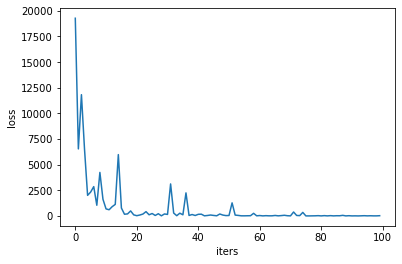

In [ ]:
import copy
import matplotlib.pyplot as plt

class DDPGAgent():
  def __init__(self, simulator, actor, critic, dim_state, dim_action, alpha, num_layers=2, states=None, actions=None,buffer=None,iters=10,batch_size=16, gamma=0.99, steps=100, Q=False):
    
    self.critic = critic
    self.critic_target = copy.deepcopy(critic)
    self.actor = actor
    
    self.buffer = buffer
    self.dim_state = dim_state
    self.dim_action = dim_action
    self.alpha = alpha
    self.num_layers = num_layers
    self.states = states.float()
    self.actions = actions.float()
    
    self.loss_fn = nn.MSELoss()
    #self.optim = opitm.Adams()
    self.iters = iters
    self.batch_size = batch_size
    self.gamma = gamma
    self.steps = steps
    self.simulator = simulator
    self.Q = Q
  
  def select_action(self,action_vec, actions):
    num_actions = actions.shape[0]
    broadcast = (action_vec * actions.to(device)).sum(dim=1)
    best = t.argmax(broadcast).item()
    
    if np.random.rand()<0.95:
      return best
    else:
      return np.random.choice(num_actions, 1)[0]
  
  def train(self):
    self.critic.train()
    losses=[]
    step = 0

    for state in self.states[0:100]: ## Each user as the start of an episode
      actions = self.actions
      for i in range(self.iters): ##length for each episode(session)
        self.critic.optimizer.zero_grad()
        self.actor.optimizer.zero_grad()
        total_Loss=0
        
        ##To select action
        # 1: actor needs to generate the action vector(deterministicly)
        # 2: use the output(vector) take the largest dot product with E greedy with all the action vectors
        action_vec = self.actor(state)
        action = self.select_action(action_vec.view(1,-1), actions) ##need to redefine
        input_simulator = t.cat((state.view(1,-1),actions[action].view(1,-1)), 1)
        
        with t.no_grad():
          reward = self.simulator(input_simulator).item()
        
        #if return positive, then update the state
        if reward >=0.5:
          state_new = state + action
        else:
          state_new = state
        done = (i==self.iters-1)
        
        self.buffer.store_transaction(state.numpy(),actions[action].numpy(),reward,state_new.numpy(), done) #need to convert to .numpy()?     
        state_batch, action_batch, reward_batch, state_next_batch, done_batch = self.buffer.sample_batch(self.batch_size)
        
        ##loss for Q values from the model
        Qs = self.critic(t.tensor(state_batch).float().to(device), t.tensor(action_batch).float().to(device))           
        ##Obtain Target Q values
        if self.Q: #Use the max value rather than new
          temp_holder = t.zeros(actions.shape[0])
          state_holder=t.zeros(state_next_batch.shape[0])

          #pick up the max q value with the next_state
          for j in range(state_next_batch.shape[0]):
            for i in range(actions.shape[0]):
              with t.no_grad():
                temp_holder[i] = self.critic_target(t.tensor(state_next_batch[j]).view(1,-1).float().to(device), actions[i].view(1,-1).float().to(device))
            state_holder[j] = t.max(temp_holder)

          targets = t.tensor(reward_batch) + self.gamma*state_holder
        else:
          action_next_vec = self.actor(t.tensor(state_next_batch).float())

          action_next = t.zeros((action_next_vec.shape[0],action_next_vec.shape[1]))
          for m,n in enumerate(action_next_vec):
            action_next[m] = self.select_action(n, actions)

          targets = t.tensor(reward_batch).view(-1,1).to(device) + self.gamma*self.critic_target(t.tensor(state_next_batch).float().to(device),action_next.to(device))

        loss_critic = self.loss_fn(Qs.view(-1,1), targets.view(-1,1).float().to(device))
        total_Loss+=loss_critic.item()     
        loss_critic.float().backward()
        ##gradient update
        self.critic.optimizer.step()
        
        
        ##Loss for the actor
        #loss_actor = -self.critic(t.tensor(state_batch).float(), self.actor(t.tensor(state_batch).float()))
        actions_next_vec = self.actor(t.tensor(state_batch).float())
        
        action_next = t.zeros((actions_next_vec.shape[0],actions_next_vec.shape[1]))
        for y,z in enumerate(actions_next_vec):
          action_next[y] = self.select_action(z, actions)

        loss_actor = -self.critic(t.tensor(state_batch).float(),action_next)
        loss_actor.mean().backward()
        self.actor.optimizer.step()
        
        ##update the target network
        step+=1
        if step % self.steps == 0:
          self.critic_target = copy.deepcopy(self.critic)       

        ##Update actions available by removing the action recommended
        actions = t.cat((actions[0:action], actions[action+1:]),0)
        state = state_new #update the state

      losses.append(total_Loss)
    self.critic.saveChk()
    self.actor.saveChk()
    print(losses)
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.plot(losses)
    
dim_state =len(state_cols)
dim_action = len(action_cols)

actor = Actor(dim_state, dim_action, 1e-4, checkpoint='actor.pt', num_layers=2)
critic = Critic(dim_state, dim_action, 1e-4, checkpoint='DDPG.pt',num_layers=2)
maxm_size = 1000 #buffer size
buffer =  replayBuffer(maxm_size,dim_state, dim_action)
agent =DDPGAgent(simulator, actor, critic, dim_state, dim_action, 1e-4, num_layers=2, states=states, actions=actions,buffer=buffer,iters=10,batch_size=16, gamma=0.99, steps=100)
agent.train()